# Testing data integrity

going to try and identify any uncropped images or otherwise messed up images, such as:

(505, 766)


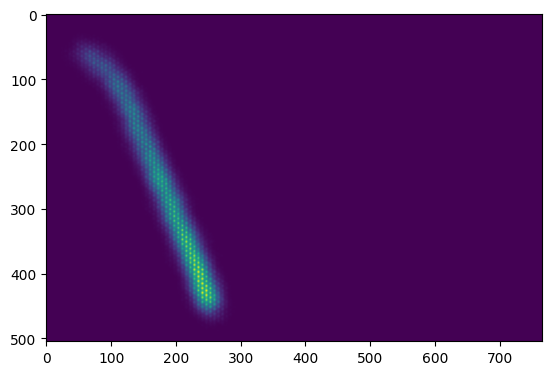

In [2]:
import sys
import os
sys.path.append(os.path.abspath('../ANN-code'))

import matplotlib.pyplot as plt
import numpy as np

sus_image_file = "../ANN-code/Data/im0/604.960keV_0.000_0.000_C_2.210cm_4704_im.npy"

image = np.load(sus_image_file)
print(image.shape)
# np.savetxt("image.csv", image, delimiter=",")

plt.imshow(image)
plt.show()

so this recoil is uncropped in x. i have planted it in the local data so it can be extracted as a test.

method i'm employing to find these problematic images:

1. Check image max_x e.g. from max_y, max_x = image.shape
2. Check largest x value max_nonzero_x with nonzero intensity (with non-noisy images)
3. Compare based on some criteria e.g. if max_nonzero_x < search_fraction * max_x 
4. Return a list of all images that satisfy this
5. Check through by hand, and adjust search fraction.
6. Repeat with same criteria for y

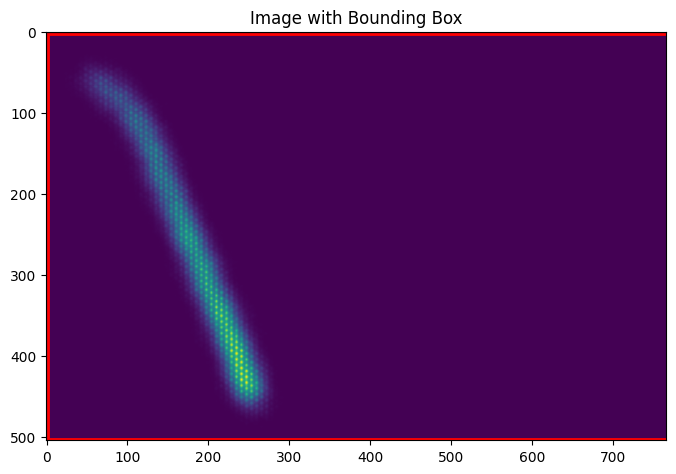

Zeroing edges of image...


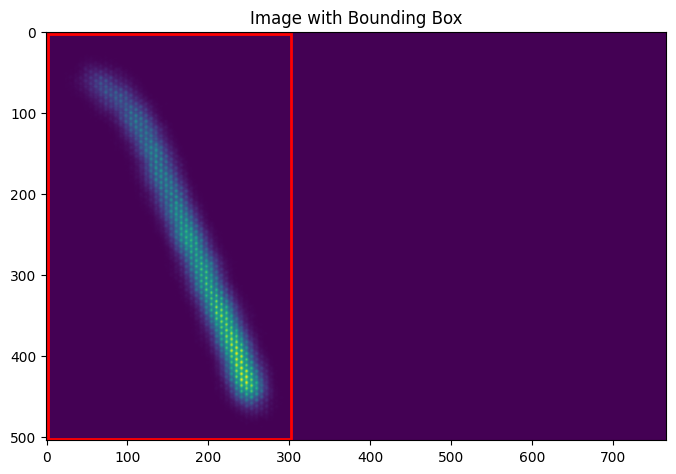

Ratio of bounding box area to image is 0.3864746787994726


In [6]:
# testing bounding box method

from feature_extraction import extract_bounding_box
from image_preprocessing import zero_edges
from image_analysis import plot_bounding_box

# plot image with bounding box
bounding_box = extract_bounding_box(image)
plot_bounding_box(image, bounding_box)

# now zero edges and plot again
print("Zeroing edges of image...")
zeroed_image = zero_edges(image, 2)
bounding_box = extract_bounding_box(zeroed_image)
plot_bounding_box(zeroed_image, bounding_box)

# area of bounding box / area of image
area_bb = (bounding_box[2] - bounding_box[0]) * (bounding_box[3] - bounding_box[1])
area_image = image.shape[0] * image.shape[1]
print("Ratio of bounding box area to image is", area_bb / area_image)

this ratio, if image is cropped well, should be close to unity

this is implemented as a check in the search method "Area Comparson"

In [19]:
# testing bounding box method on 10 events

from data_methods import create_file_paths
from bb_event import Event

data_path = ["../ANN-code/Data/im0"]

file_paths = create_file_paths(data_path)

events = []
file_paths = np.random.choice(file_paths, size=10, replace=True)
for file in file_paths:
    events.append(Event(file, np.load(file)))

print("Number of events loaded: ", len(events))

100%|██████████| 2027/2027 [00:00<00:00, 633238.06it/s]


Number of events loaded:  2000


Number of events with bounding box is 1989 out of 2000
Mean ratio of bounding box area to image area is 0.843872531669799
Standard deviation of ratio of bounding box area to image area is 0.08214176367862372


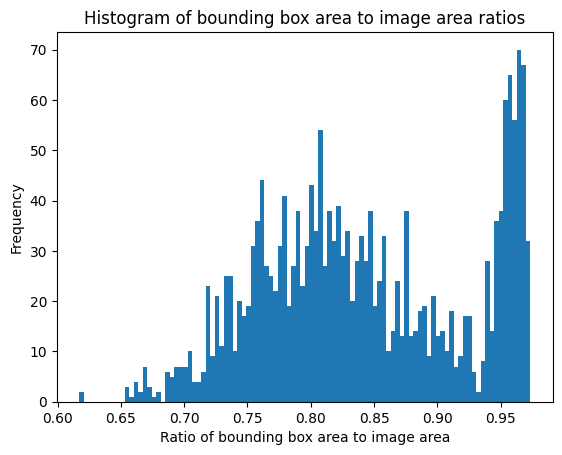

Number of events with ratio < 0.6 is 0
0.5th percentile of ratios is 0.6664710757626449


In [34]:
# for the 10 events, plot the image with bounding box, then zero edges and plot again. repeat with new figure for each event
# also print the ratio of bounding box area to image area

from image_preprocessing import uncropped_check
from feature_extraction import extract_bounding_box

ratios = []

for event in events:

    zeroed_image = zero_edges(event.image, 2)
    bounding_box = extract_bounding_box(zeroed_image)
    # plot_bounding_box(zeroed_image, bounding_box) # uncomment to plot bounding box on zeroed image

    # area of bounding box / area of image
    if bounding_box is None:
        continue

    area_bb = (bounding_box[2] - bounding_box[0]) * (bounding_box[3] - bounding_box[1])
    area_image = event.image.shape[0] * event.image.shape[1]
    # print("Ratio of bounding box area to image is", area_bb / area_image) # uncomment to print ratio
    ratios.append(area_bb / area_image)

    plt.show()
    plt.close()

print("Number of events with bounding box is", len(ratios), "out of", len(events))
print("Mean ratio of bounding box area to image area is", np.mean(ratios))
print("Standard deviation of ratio of bounding box area to image area is", np.std(ratios))

# plot histogram of ratios
plt.hist(ratios, bins=100)
plt.xlabel("Ratio of bounding box area to image area")
plt.ylabel("Frequency")
plt.title("Histogram of bounding box area to image area ratios")
plt.show()

# print the number of events with ratio < 0.6
print("Number of events with ratio < 0.6 is", len([r for r in ratios if r < 0.6]))

# the ratio of the areas can be considered a search parameter

# don't mind searching through ~0.5% of the data, so find the 0.5th percentile of the ratios
print("0.5th percentile of ratios is", np.percentile(ratios, 0.5))

From a run with 2000 images:

Mean ratio of bounding box area to image area is 0.843872531669799
Standard deviation of ratio of bounding box area to image area is 0.08214176367862372

Seems that most should be quite high here.

0.5th percentile of ratios is 0.66
So choosing <0.65 as search statistic

In [32]:
# testing the max comparison method in uncropped check on the local data

from data_methods import create_file_paths
from bb_event import Event

data_path = ["../ANN-code/Data/im0"]

file_paths = create_file_paths(data_path)

events = []
file_paths = np.random.choice(file_paths, size=2000, replace=True)
for file in file_paths:
    events.append(Event(file, np.load(file)))

print("Number of events loaded: ", len(events))

100%|██████████| 2027/2027 [00:00<00:00, 634230.08it/s]


Number of events loaded:  2000


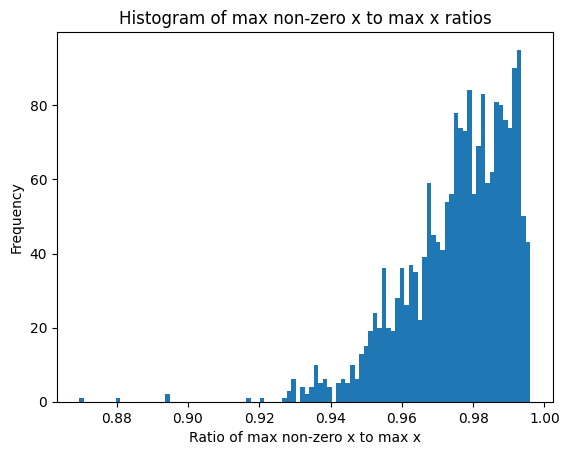

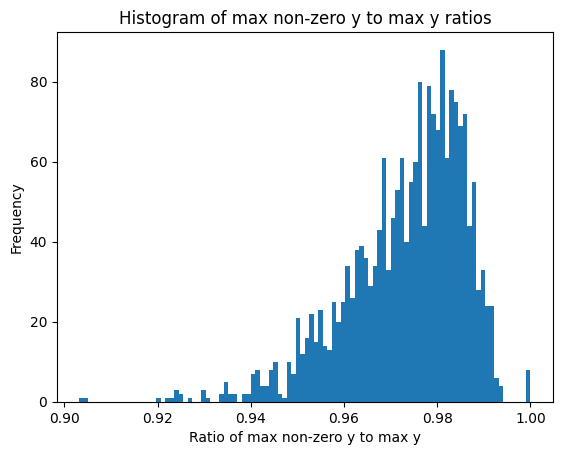

0.5th percentile of max_x_ratios is 0.9293949579831933
0.5th percentile of max_y_ratios is 0.9264317425083242


In [33]:
max_x_ratios = []
max_y_ratios = []

for event in events:

    image = event.image
    max_y, max_x = image.shape
    # Determine a threshold intensity to avoid floating point errors
    non_zero_values = image[image > 0]
    if non_zero_values.size == 0:
        continue  # No non-zero pixels, so cannot determine uncropped status

    threshold = np.percentile(
        non_zero_values, 1
    )  # Smallest 1% of non-zero intensities

    # Find the largest x and y coordinates with intensity greater than the threshold
    nonzero_indices = np.argwhere(image > threshold)
    if nonzero_indices.size == 0:
        continue  # No valid indices after applying threshold

    max_nonzero_y = nonzero_indices[:, 0].max() + 1  # Add 1 to account for indexing
    max_nonzero_x = nonzero_indices[:, 1].max() + 1

    # Compare max_nonzero_x and max_nonzero_y with thresholds
    # calculate max_nonzero_x and max_nonzero_y as a fraction of the max_x and max_y

    max_x_ratio = max_nonzero_x / max_x
    max_y_ratio = max_nonzero_y / max_y

    max_x_ratios.append(max_x_ratio)
    max_y_ratios.append(max_y_ratio)


# plot histograms of max_x_ratios and max_y_ratios

plt.hist(max_x_ratios, bins=100)
plt.xlabel("Ratio of max non-zero x to max x")
plt.ylabel("Frequency")
plt.title("Histogram of max non-zero x to max x ratios")
plt.show()

plt.hist(max_y_ratios, bins=100)
plt.xlabel("Ratio of max non-zero y to max y")
plt.ylabel("Frequency")
plt.title("Histogram of max non-zero y to max y ratios")
plt.show()

# don't mind searching through ~0.5% of the data, so find the 0.5th percentile of the max_x_ratios and max_y_ratios

print("0.5th percentile of max_x_ratios is", np.percentile(max_x_ratios, 0.5))
print("0.5th percentile of max_y_ratios is", np.percentile(max_y_ratios, 0.5))

Therefore, based on 2000 samples, the search parameter will be 0.92.

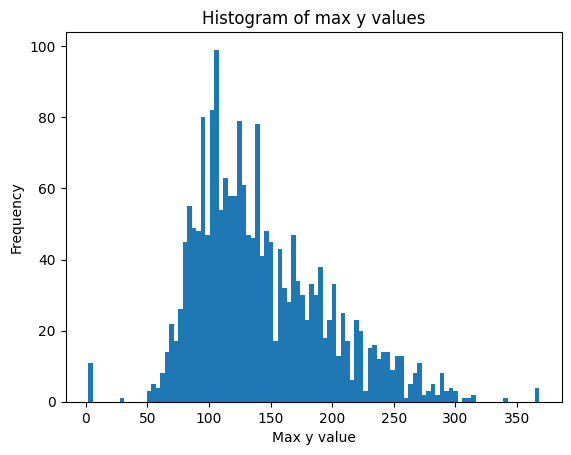

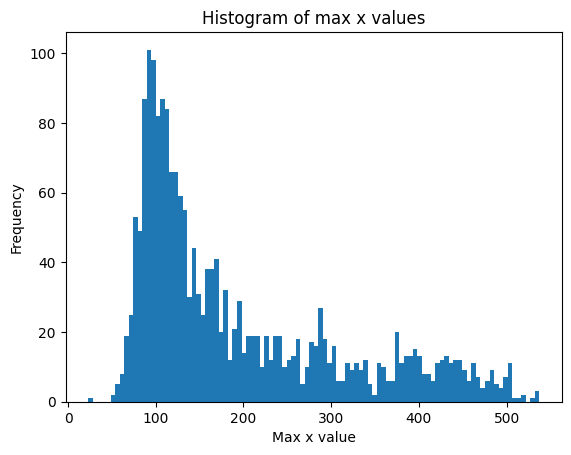

0.5th percentile of max_y_values is 2.0
0.5th percentile of max_x_values is 61.995000000000005


In [36]:
# min dim check

# list of image max_y, max_x values
max_y_values = []
max_x_values = []

for event in events:

    max_y, max_x = event.image.shape
    max_y_values.append(max_y)
    max_x_values.append(max_x)

# histogram of max_y_values and max_x_values

plt.hist(max_y_values, bins=100)
plt.xlabel("Max y value")
plt.ylabel("Frequency")
plt.title("Histogram of max y values")
plt.show()

plt.hist(max_x_values, bins=100)
plt.xlabel("Max x value")
plt.ylabel("Frequency")
plt.title("Histogram of max x values")
plt.show()

# don't mind searching through ~0.5% of the data, so find the 0.5th percentile of the max_y_values and max_x_values

print("0.5th percentile of max_y_values is", np.percentile(max_y_values, 0.5))
print("0.5th percentile of max_x_values is", np.percentile(max_x_values, 0.5))
    

In [38]:
# checking for problematic images using my test functions
import os
import sys
from tqdm import tqdm

print("Current working directory: ", os.getcwd())

from image_preprocessing import uncropped_check, dim_check, zero_edges


# Directories to check
im_dirs = [
    "../ANN-code/Data/im0",
    ]

# check all images in the directory (end in .npy)
min_dim_error = []
uncropped_error = []

# ssearch criteria
min_dim = 10
max_comparison_search_fraction = 0.90
area_comparison_search_fraction = 0.63

for im_dir in im_dirs:
    for file in tqdm(os.listdir(im_dir)):
        if file.endswith(".npy"):
            im_file = os.path.join(im_dir, file)
            image = np.load(im_file)

            if dim_check(image, min_dim):
                min_dim_error.append(im_file)
                continue

            if uncropped_check(zero_edges(image, 2), search_fraction=max_comparison_search_fraction, method='max_comparison'):
                uncropped_error.append(im_file)
                continue

            if uncropped_check(zero_edges(image, 2), search_fraction=area_comparison_search_fraction, method='area_comparison'):
                uncropped_error.append(im_file)
                

print("Number of images that violate the minimum dimension criteria: ", len(min_dim_error))
print("Number of images that violate the uncropped criteria: ", len(uncropped_error))

# save the min_dim_error and uncropped_error lists as csv files

# np.savetxt("min_dim_error.csv", min_dim_error, delimiter=",", fmt="%s")
# np.savetxt("uncropped_error.csv", uncropped_error, delimiter=",", fmt="%s")


Current working directory:  /Users/benstevens/MIGDAL/NR-ANN/notebooks


100%|██████████| 2027/2027 [00:01<00:00, 1428.32it/s]

Number of images that violate the minimum dimension criteria:  9
Number of images that violate the uncropped criteria:  6


In [ ]:
# now manual check on the identified min_dim_error and uncropped_error images

# widget for manual check
import sys, os
sys.path.append(os.path.abspath('../ANN-code'))

from bb_event import Event
import random
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import Button, VBox, HBox, Output, Label

# Load uncropped events (change if needed)
uncropped = np.loadtxt('../ANN-code/uncropped_error.csv', delimiter=',', dtype=str)

# Initialize events
events = []
for file in uncropped:
    im = np.load(file)
    events.append(Event(file, im))

# Track corrected events
corrected_list = []

# Initialize output
out = Output()

# Display next event
def display_event():
    with out:
        out.clear_output()
        if events:
            event = random.choice(events)
            events.remove(event)
            plt.imshow(event.image, cmap='gray')
            plt.title(event.name)
            plt.axis('off')
            plt.show()
            return event
        else:
            print("No more events to inspect!")
            return None

# Event to inspect
current_event = display_event()

# Handle "Accept" button
def accept_event(b):
    global current_event
    with out:
        if current_event:
            print(f"Accepted event: {current_event.name}")
        current_event = display_event()


# Handle "Reject" button
def reject_event(b):
    global current_event
    with out:
        if current_event:
            corrected_list.append(str(current_event.name))
            print(f"Rejected event: {current_event.name}")
        current_event = display_event()

# Create buttons
accept_button = Button(description="Accept", button_style="success")
reject_button = Button(description="Reject", button_style="danger")

# Button click handlers
accept_button.on_click(accept_event)
reject_button.on_click(reject_event)

# Layout
label = Label(f"Remaining events: {len(events)}")
def update_label():
    label.value = f"Remaining events: {len(events)}"

def update_event_list(b):
    update_label()

accept_button.on_click(update_event_list)
reject_button.on_click(update_event_list)

buttons = HBox([accept_button, reject_button])
layout = VBox([label, buttons, out])

# Display
display(layout)

In [ ]:
print(corrected_list)

### checking the true positive anomalies

In [48]:
# checking the final lists

import numpy as np
import matplotlib.pyplot as plt

real_min_dim = np.loadtxt('min_dim_list_true.csv', delimiter=',', dtype=str)

ims = []

for file in real_min_dim:
    ims.append(np.load(file))

print(len(ims))

for im in ims:
    plt.imshow(im)
    plt.show()


/vols/lz/tmarley/GEM_ITO/run/im4/C/337.121keV_0.000_0.000_C_1.628cm_3751_im.npy
/vols/lz/tmarley/GEM_ITO/run/im4/C/337.121keV_0.000_0.000_C_1.628cm_3751_im.npy
